In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
import gc
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import datatable as dt
import matplotlib.pyplot as plt
import joblib


dtypes={'row_id': 'int64',
                          'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'task_container_id': 'int16',
                          'user_answer': 'int8',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean',
                          'max_time_stamp' : 'int64',
                          'viretual_time_stamp' : 'int64'}

target = 'answered_correctly'

train_df = dt.fread("(adjusted)train.csv", columns=set(dtypes.keys())).to_pandas()
lectures_df = pd.read_csv("lectures.csv")

lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')
lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])
part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]
types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of')]

train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')
user_lecture_stats_part = train_lectures.groupby('user_id', as_index=False)[part_lectures_columns + types_of_lectures_columns].sum()

In [2]:
gc.collect()

20

In [3]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}

user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

In [4]:
del train_lectures

In [5]:
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
cum['cumcount'] = cum['cumcount'] + 1
train_df['user_interaction_count'] = cum['cumcount']
train_df['user_interaction_viretual_time_stamp_mean'] = train_df['viretual_time_stamp']/cum['cumcount']
train_df['user_lecture_sum'] = cum['cumsum']
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']

train_df.user_lecture_lv = train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_sum = train_df.user_lecture_sum.astype('int16')
train_df.user_interaction_count=train_df.user_interaction_count.astype('int16')
train_df['user_interaction_viretual_time_stamp_mean'] = train_df['user_interaction_viretual_time_stamp_mean']/(1000*3600)
train_df['user_interaction_viretual_time_stamp_mean'] = train_df['user_interaction_viretual_time_stamp_mean'].astype('float32')
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])
user_lecture_agg = user_lecture_agg.astype('int16')

In [6]:
del cum
gc.collect()

20

In [7]:
max_timestamp_u = train_df[['user_id', 'timestamp']].groupby('user_id').agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
max_timestamp_u.user_id = max_timestamp_u.user_id.astype('int32')

max_viretual_stamp_u = train_df[['user_id', 'viretual_time_stamp']].groupby('user_id').agg(['max']).reset_index()
max_viretual_stamp_u.columns = ['user_id', 'max_viretual_time_stamp']
max_viretual_stamp_u.user_id = max_viretual_stamp_u.user_id.astype('int32')



In [69]:
gc.collect()

200

In [9]:
train_df['lagtime'] = train_df.groupby('user_id')['viretual_time_stamp'].shift()
train_df['temp_lag_time'] = train_df.groupby('user_id')['timestamp'].shift()

max_timestamp_u2 = train_df[['user_id', 'temp_lag_time']].groupby('user_id').agg(['max']).reset_index()
max_timestamp_u2.columns = ['user_id', 'temp_max_time_stamp2']
max_timestamp_u2.user_id = max_timestamp_u2.user_id.astype('int32')
#max_timestamp_u2['temp_max_time_stamp2'].fillna

max_viretual_stamp_u2 = train_df[['user_id', 'lagtime']].groupby('user_id').agg(['max']).reset_index()
max_viretual_stamp_u2.columns = ['user_id', 'max_viretual_time_stamp2']
max_viretual_stamp_u2.user_id = max_viretual_stamp_u2.user_id.astype('int32')



train_df['lagtime'] = train_df['viretual_time_stamp'] - train_df['lagtime']
lagtime_mean = train_df['lagtime'].mean()
train_df['lagtime'].fillna(lagtime_mean, inplace=True)
train_df['lagtime'] = train_df['lagtime'] / (1000*3600)
train_df['lagtime'] = train_df.lagtime.astype('float32')

In [10]:
gc.collect()

20

In [11]:
train_df['lagtime2'] = train_df.groupby('user_id')['viretual_time_stamp'].shift(2)
train_df['temp_lag_time2'] = train_df.groupby('user_id')['timestamp'].shift(2)

max_timestamp_u3 = train_df[['user_id', 'temp_lag_time2']].groupby('user_id').agg(['max']).reset_index()
max_timestamp_u3.columns = ['user_id', 'temp_max_time_stamp3']
max_timestamp_u3.user_id = max_timestamp_u3.user_id.astype('int32')

max_viretual_stamp_u3 = train_df[['user_id', 'lagtime2']].groupby('user_id').agg(['max']).reset_index()
max_viretual_stamp_u3.columns = ['user_id', 'max_viretual_time_stamp3']
max_viretual_stamp_u3.user_id = max_viretual_stamp_u3.user_id.astype('int32')


train_df['lagtime2'] = train_df['viretual_time_stamp'] - train_df['lagtime2']
lagtime_mean2 = train_df['lagtime2'].mean()
train_df['lagtime2'].fillna(lagtime_mean2, inplace=True)
train_df['lagtime2'] = train_df['lagtime2'] / (1000*3600)
train_df.lagtime2 = train_df.lagtime2.astype('float32')

gc.collect()

train_df['lagtime3'] = train_df.groupby('user_id')['viretual_time_stamp'].shift(3)
train_df['lagtime3'] = train_df['viretual_time_stamp'] - train_df['lagtime3']
lagtime_mean3 = train_df['lagtime3'].mean()
train_df['lagtime3'].fillna(lagtime_mean3, inplace=True)
train_df['lagtime3'] = train_df['lagtime3']/(1000*3600)
train_df.lagtime3 = train_df.lagtime3.astype('float32')

In [12]:
lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean'])
train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean'])
train_df.lagtime_mean = train_df.lagtime_mean.astype('int32')
gc.collect()

20

In [13]:
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

In [14]:
user_prior_question_elapsed_time = train_df[['user_id', 'prior_question_elapsed_time']].groupby(['user_id']).tail(1)
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']
user_prior_question_elapsed_time_dict= user_prior_question_elapsed_time.set_index("user_id").to_dict()

train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'] - train_df['delta_prior_question_elapsed_time']


delta_prior_question_elapsed_time_mean = train_df['delta_prior_question_elapsed_time'].mean()
train_df['delta_prior_question_elapsed_time'].fillna(delta_prior_question_elapsed_time_mean, inplace=True)
train_df.delta_prior_question_elapsed_time = train_df.delta_prior_question_elapsed_time.astype('int32')
gc.collect()

0

In [15]:
train_df['viretual_time_stamp'] = train_df['viretual_time_stamp']/(1000*3600)
train_df['viretual_time_stamp'] = train_df['viretual_time_stamp'].astype('int16')

In [16]:
gc.collect()

40

In [17]:
#train_df = train_df.loc[train_df['content_type_id']==0].reset_index(drop=True)

In [18]:
gc.collect()

40

In [19]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
user_agg = train_df.groupby('user_id')['lag'].agg(['sum', 'count']).astype('int16')
cum['cumsum'].fillna(0, inplace=True)

train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_count'] = cum['cumsum']
train_df['user_uncorrect_count'] = cum['cumcount'] - cum['cumsum']
#train_df['user_correct_cumsum'] = cum['cumsum']
#train_df['user_correct_cumcount'] = cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)
train_df['user_correctness'].fillna(0.67, inplace=True)
#train_df['user_correct_cumsum'].fillna(0, inplace=True)
train_df.user_correctness = train_df.user_correctness.astype('float16')
train_df.user_correct_count = train_df.user_correct_count.astype('int16')
train_df.user_uncorrect_count = train_df.user_uncorrect_count.astype('int16')
gc.collect()

0

In [20]:
train_df.prior_question_had_explanation.fillna(False, inplace=True)
train_df.prior_question_had_explanation = train_df.prior_question_had_explanation.astype('int8')

content_explanation_agg = train_df[['content_id', "prior_question_had_explanation",target]]\
                          .groupby(['content_id', 'prior_question_had_explanation'])[target].agg(['mean'])
content_explanation_agg = content_explanation_agg.unstack()
content_explanation_agg = content_explanation_agg.reset_index()
content_explanation_agg.columns = ['content_id', 'content_explanation_false_mean','content_explanation_true_mean']
content_explanation_agg.content_id=content_explanation_agg.content_id.astype('int16')
content_explanation_agg.content_explation_false_mean=content_explanation_agg.content_explanation_false_mean.astype('float16')
content_explanation_agg.content_explation_true_mean=content_explanation_agg.content_explanation_true_mean.astype('float16')

C:\Users\gerard\anaconda3\envs\riid\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gerard\anaconda3\envs\riid\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()


In [21]:
cum = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['cumsum', 'cumcount'])
cum['comcount'] = cum['cumcount'] + 1
#user_agg = train_df.groupby('user_id')['lag'].agg(['sum', 'count']).astype('int16')
cum['cumsum'].fillna(0, inplace=True)


train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_true_count'] = cum['cumsum']
train_df['explanation_false_count'] = cum['cumcount'] - cum['cumsum']
#train_df.drop(columns=['lag'], inplace=True)
train_df.explanation_mean = train_df.explanation_mean.astype('float16')

train_df['explanation_mean'].fillna(train_df.explanation_mean, inplace=True)
#train_df['explanation_cumsum'].fillna(0, inplace=True)
train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_true_count=train_df.explanation_true_count.astype('int16')
train_df.explanation_false_count=train_df.explanation_false_count.astype('int16')

In [22]:
del cum

In [23]:
gc.collect()

40

In [24]:
train_df['attempt_no'] = 1
train_df.attempt_no = train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[['user_id', 'content_id', 'attempt_no']].groupby(['user_id', 'content_id'])['attempt_no'].cumsum()
attempt_no_agg = train_df.groupby(['user_id', 'content_id'])['attempt_no'].agg(['sum']).astype('int8')
attempt_no_agg = attempt_no_agg[attempt_no_agg['sum'] > 1]
gc.collect()

20

In [25]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,lagtime3,lagtime_mean,delta_prior_question_elapsed_time,user_correctness,user_correct_count,user_uncorrect_count,explanation_mean,explanation_true_count,explanation_false_count,attempt_no
0,32933156,0,705741139,128,False,0,0,1,25423.810043,0,...,16.355442,4,-4,0.669922,0,0,NaN,0,0,1
1,32933157,20666,705741139,7860,False,1,0,1,16000.000000,0,...,16.355442,4,-9423,1.000000,1,0,0.0,0,1,1
2,32933158,39172,705741139,7922,False,2,1,1,19000.000000,0,...,16.355442,4,3000,1.000000,2,0,0.0,0,2,1
3,32933159,58207,705741139,156,False,3,2,1,17000.000000,0,...,0.016169,4,-2000,1.000000,3,0,0.0,0,3,1
4,32933160,75779,705741139,51,False,4,0,1,17000.000000,0,...,0.015309,4,0,1.000000,4,0,0.0,0,4,1


In [26]:
train_df.shape

(101230332, 30)

In [27]:
gc.collect()

40

In [28]:
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg = explanation_agg.astype('int16')

user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count', 'var'])

user_agg = user_agg.astype('int16')
content_agg = content_agg.astype('float32')
task_container_agg = task_container_agg.astype('float32')

In [29]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_correctness'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])
train_df.content_correctness = train_df.content_correctness.astype('float16')
gc.collect()

train_df['task_container_uncor_count'] = train_df['task_container_id'].map(task_container_agg['count'] - task_container_agg['sum']).astype('int32')
train_df['task_container_cor_count'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness = train_df.task_container_correctness.astype('float16')

gc.collect()

0

In [30]:
content_elapsed_time_agg = train_df.groupby('content_id')['prior_question_elapsed_time'].agg(['mean'])
content_had_explanation_agg = train_df.groupby('content_id')['prior_question_had_explanation'].agg(['mean'])

In [31]:
questions_df = pd.read_csv('questions.csv')

In [32]:
bundle_agg = questions_df.groupby('bundle_id')['question_id'].agg(['count'])
questions_df['content_sub_bundle'] = questions_df['bundle_id'].map(bundle_agg['count']).astype('int8')

In [33]:
questions_df['tags'].fillna('188', inplace=True)

In [34]:
def gettags(tags, num):
    tags_splits=tags.split(" ")
    result='' 
    for t in tags_splits:
        x=int(t)
        if(x<32*(num+1) and x>=32*num):#num 
            result=result+' '+t
        if result.startswith(" "):
            result = result.strip()
            
    return result
gettags("11 12 13 14", 0)

'11 12 13 14'

In [35]:
from sklearn.preprocessing import LabelEncoder
for num in range(0,7):
    questions_df["tags"+str(num)] = questions_df["tags"].apply(lambda row: gettags(row,num))
    le = LabelEncoder()
    le.fit(np.unique(questions_df['tags'+str(num)].values))
    #questions_df[['tags'+str(num)]=
    questions_df['tags'+str(num)]=questions_df[['tags'+str(num)]].apply(le.transform)

In [36]:
questions_df_dict = {
    'tags0' : 'int8',
    'tags1' : 'int8',
    'tags2' : 'int8',
    'tags3' : 'int8',
    'tags4' : 'int8',
    'tags5' : 'int8',
    'tags6' : 'int8',
}

In [37]:
questions_df.drop(columns=['tags'], inplace=True)

In [38]:
questions_df['part_bundle_id'] = questions_df['part']*100000 + questions_df['bundle_id']
questions_df.part_bundle_id = questions_df.part_bundle_id.astype('int32')
#tag = questions_df['tags'].str.split(" ", n=10, expand=True)
#tag.columns = ['tags'+str(x) for x in range(1,7)]

#tag.fillna(0, inplace=True)
#tag = tag.astype('int16')
#questions_df = pd.concat([questions_df, tag], axis=1).drop(['tags'], axis=1)

In [39]:
questions_cmnts = pd.read_csv(
    'question_cmnts.csv',
    dtype={'question_id': 'int16','community': 'int8'}
)

In [40]:
questions_df = pd.merge(questions_df, questions_cmnts, on='question_id', how='left', right_index=True)
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [41]:
questions_df = pd.merge(questions_df, content_explanation_agg, on='content_id', how='left')

del content_explanation_agg
gc.collect()

80

In [42]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness = questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std = questions_df.content_correctness_std.astype('float16')

questions_df['content_uncorrect_count'] = questions_df['content_id'].map(content_agg['count'] - content_agg['sum']).astype('int32')
questions_df['content_correct_count'] = questions_df['content_id'].map(content_agg['sum']).astype('int32')

In [43]:
gc.collect()

40

In [44]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [45]:
part_agg = questions_df.groupby('part')['content_uncorrect_count'].agg(['sum'])
questions_df['part_uncor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')
part_agg = questions_df.groupby('part')['content_correct_count'].agg(['sum'])
questions_df['part_cor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')

In [46]:
questions_df['content_elapsed_time_mean'] = questions_df['content_id'].map(content_elapsed_time_agg['mean'])
questions_df.content_elapsed_time_mean = questions_df.content_elapsed_time_mean.astype('float16')
questions_df['content_had_explanation_mean'] = questions_df['content_id'].map(content_had_explanation_agg['mean'])
questions_df.content_had_explanation_mean=questions_df.content_had_explanation_mean.astype('float16')
gc.collect()

20

In [47]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness = questions_df.bundle_correctness.astype('float16')

In [49]:
questions_df.drop(columns=['content_correctness'], inplace=True)

In [50]:
train_df = train_df.merge(questions_df, on='content_id', how='left', right_index=True)

In [51]:
gc.collect()

20

In [52]:
part_user_agg = train_df.groupby(['user_id', 'part'])['answered_correctly'].agg(['mean', 'count'])
part_user_agg.head(5)

mean  count
user_id part                 
115     1.0   0.702703     37
        2.0   1.000000      1
        3.0   0.666667      3
        4.0   0.333333      3
        5.0   1.000000      2

In [53]:
train_df['part_acc'] = train_df['part'].map(part_user_agg['mean'])
train_df['part_count'] = train_df['part'].map(part_user_agg['count'])
gc.collect()

0

In [16]:
features_dict = {
    #'user_id',
    'viretual_time_stamp':'float16',#
    'user_interaction_count':'int16',
    'user_interaction_viretual_time_stamp_mean':'float32',
    'lagtime':'float32',#
    'lagtime2':'float32',
    'lagtime3':'float32',
    #'lagtime_mean':'int32',
    'content_id':'int16',
    'task_container_id':'int16',
    'user_lecture_sum':'int16',#
    'user_lecture_lv':'float16',##
    'prior_question_elapsed_time':'float32',#
    'delta_prior_question_elapsed_time':'int32',#
    'user_correctness':'float16',#
    'user_uncorrect_count':'int16',#
    'user_correct_count':'int16',#
    #'content_correctness':'float16',
    'content_correctness_std':'float16',
    'content_correct_count':'int32',
    'content_uncorrect_count':'int32',#
    'content_elapsed_time_mean':'float16',
    'content_had_explanation_mean':'float16',
    'content_explanation_false_mean':'float16',
    'content_explanation_true_mean':'float16',
    'task_container_correctness':'float16',
    'task_container_std':'float16',
    'task_container_cor_count':'int32',#
    'task_container_uncor_count':'int32',#
    'attempt_no':'int8',#
    'part':'int8',
    'part_correctness_mean':'float16',
    'part_correctness_std':'float16',
    'part_uncor_count':'int32',
    'part_cor_count':'int32',
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
    'tags6': 'int8',
   # 'tags7': 'int8',
#     'tags0_correctness_mean':'float16',
#     'tags1_correctness_mean':'float16',
#     'tags2_correctness_mean':'float16',
#     'tags4_correctness_mean':'float16',
#     'bundle_id':'int16',
#     'bundle_correctness_mean':'float16',
#     'bundle_uncor_count':'int32',
#     'bundle_cor_count':'int32',
    'part_bundle_id':'int32',
    'content_sub_bundle':'int8',
    'prior_question_had_explanation':'int8',
    'explanation_mean':'float16', #
    #'explanation_var',#
    'explanation_false_count':'int16',#
    'explanation_true_count':'int16',#
    'community':'int8',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
}
categorical_columns= [
    #'user_id',
    'content_id',
    'task_container_id',
    'part',
    'community',
    'tags0',
    'tags1',
    'tags2',
    'tags3',
    'tags4',
    'tags5',
    'tags6',
    #'tags7',
    #'bundle_id',
    'part_bundle_id',
    'content_sub_bundle',
    'prior_question_had_explanation', 
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]

features=list(features_dict.keys())

In [56]:
flag_lgbm=True
clfs = list()
params = {
'num_leaves': 350,
'max_bin':700,
'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.58,
'bagging_fraction': 0.58,
#'min_data_in_leaf': 106,
'objective': 'binary',
'max_depth': -1,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
'random_state': 47
}
trains=list()
valids=list()
num=7
for i in range(0,num):
  
    #train_df=train_df.reset_index(drop=True)
    train_df_clf=train_df[1200*10000*i:1200*10000*(i+1)]
    print('sample end')
    #train_df.drop(train_df_clf.index, inplace=True)
    #print('train_df drop end')
    
   
    #del train_df
    
    users=train_df_clf['user_id'].drop_duplicates()#去重
    
    users=users.sample(frac=0.025)
    users_df=pd.DataFrame()
    users_df['user_id']=users.values
  
  
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner',right_index=True)
    del users_df
    del users
    gc.collect()
    #
    train_df_clf.drop(valid_df_newuser.index, inplace=True)
   
    #-----------
    #train_df_clf=train_df_clf.sample(frac=0.2)
    #train_df_clf.drop(valid_df_newuser.index, inplace=True)
    #train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left',right_index=True)#
    #valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left',right_index=True)#
    
#     train_df_clf = pd.merge(train_df_clf, user_lecture_stats_part, on='user_id', how="left",right_index=True)
#     valid_df_newuser = pd.merge(valid_df_newuser, user_lecture_stats_part, on='user_id', how="left",right_index=True)

    valid_df=train_df_clf.sample(frac=0.15)
    train_df_clf.drop(valid_df.index, inplace=True)
   
    valid_df = valid_df.append(valid_df_newuser)
    del valid_df_newuser
    gc.collect()
    #

    trains.append(train_df_clf)
    valids.append(valid_df)
    print('valid_df length：',len(valid_df))

sample end


C:\Users\gerard\anaconda3\envs\riid\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


valid_df length： 2047980
sample end
valid_df length： 2044362
sample end
valid_df length： 2047521
sample end
valid_df length： 2034838
sample end
valid_df length： 2052605
sample end
valid_df length： 2054878
sample end
valid_df length： 2043338


C:\Users\gerard\anaconda3\envs\riid\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community', 'content_id', 'content_sub_bundle', 'part', 'part_bundle_id', 'prior_question_had_explanation', 'tags0', 'tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'tags6', 'task_container_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\gerard\anaconda3\envs\riid\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\gerard\anaconda3\envs\riid\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.788581	valid_1's auc: 0.780033
[100]	training's auc: 0.801999	valid_1's auc: 0.784759
[150]	training's auc: 0.811053	valid_1's auc: 0.786174
[200]	training's auc: 0.818034	valid_1's auc: 0.78654
[250]	training's auc: 0.823358	valid_1's auc: 0.786634
Early stopping, best iteration is:
[226]	training's auc: 0.820871	valid_1's auc: 0.786698


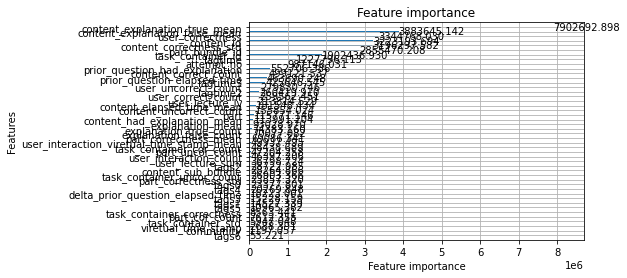

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.789682	valid_1's auc: 0.780811
[100]	training's auc: 0.802936	valid_1's auc: 0.78532
[150]	training's auc: 0.811838	valid_1's auc: 0.786737
[200]	training's auc: 0.818788	valid_1's auc: 0.787148
[250]	training's auc: 0.823951	valid_1's auc: 0.787258
Early stopping, best iteration is:
[242]	training's auc: 0.823214	valid_1's auc: 0.787291


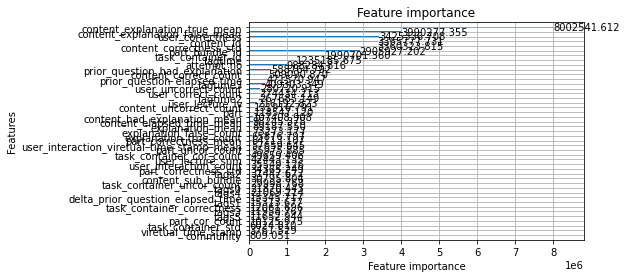

In [57]:
#del train_df
#fillna
import lightgbm as lgb
import pickle
for i in range(5,num):

#     
    tr_data = lgb.Dataset(trains[i][features], label=trains[i][target])
    va_data = lgb.Dataset(valids[i][features], label=valids[i][target])
    
#     del train_df_clf
#     del valid_df
#     gc.collect()
    #del trains
    #del valids
    #gc.collect()

    model = lgb.train(
        params, 
        tr_data,
#         train_df[features],
#         train_df[target],
        num_boost_round=5000,
        #valid_sets=[(train_df[features],train_df[target]), (valid_df[features],valid_df[target])], 
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
    f = open(f"lgb_model{i}.pkl", 'wb')
    pickle.dump(model, f)
    f.close()
    clfs.append(model)
    #print('auc:', roc_auc_score(valid_df[target], model.predict(valid_df[features])))
    #model.save_model(f'model.txt')
    lgb.plot_importance(model, importance_type='gain')
    plt.show()
    #del lgb
    #del tr_data
    #del va_data
    gc.collect()

In [169]:
from collections import defaultdict
import lightgbm as lgb
import pickle

In [170]:
def get_max_attempt(user_id, content_id):
    k = (user_id, content_id)
    
    if k in attempt_no_sum_dict.keys():
        attempt_no_sum_dict[k]+=1
        return attempt_no_sum_dict[k]
    
    attempt_no_sum_dict[k] = 1
    return attempt_no_sum_dict[k]

In [171]:
## 상수 지정
prior_question_elapsed_time_mean = 25423.810042960275
lagtime_mean = 20061832.085456338
lagtime_mean2 = 39610585.65514838
lagtime_mean3 = 58879590.7244385
delta_prior_question_elapsed_time_mean = -4.699396307358232
prior_question_elapsed_time_mean = 25423.810042960275
timestamp_max = 43712886024
prior_question_elapsed_time_mean 

25423.810042960275

In [172]:
gc.collect()

169

In [173]:
# PKL LOAD
### PKL SAVE
with open("max_viretual_stamp_u.pkl", 'rb') as f:
    max_viretual_stamp_u = pickle.load(f)
with open("max_viretual_stamp_u2.pkl", 'rb') as f:
    max_viretual_stamp_u2 = pickle.load(f)
with open("max_viretual_stamp_u3.pkl", 'rb') as f:
    max_viretual_stamp_u3 = pickle.load(f)
with open("user_prior_question_elapsed_time.pkl", 'rb') as f:
    #user_prior_question_elapsed_time_dict = defaultdict(float, user_prior_question_elapsed_time_dict)
    user_prior_question_elapsed_time = pickle.load(f)

with open("user_prior_question_elapsed_time_dict", "rb") as f:
    user_prior_question_elapsed_time_dict = pickle.load(f)
    
#user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
with open("user_sum_dict.pkl", 'rb') as f:
    user_sum_dict = pickle.load(f)

#user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
with open("user_count_dict.pkl", 'rb') as f:
    user_count_dict = pickle.load(f)
    

#task_container_sum_dict = task_container_agg['sum'].astype('int16').to_dict(defaultdict(int))
with open("task_container_sum_dict.pkl", 'rb') as f:
    task_container_sum_dict = pickle.load(f)

#task_container_count_dict = task_container_agg['count'].astype('int32').to_dict(defaultdict(int))
with open("task_container_count_dict.pkl", 'rb') as f:
    task_container_count_dict = pickle.load(f)
    
#task_container_std_dict = task_container_agg['var'].astype('float16').to_dict(defaultdict(float))
with open("task_container_std_dict.pkl", 'rb') as f:
    task_container_std_dict = pickle.load(f)

#explanation_sum_dict = explanation_agg['sum'].astype('int16').to_dict(defaultdict(int))
with open("explanation_sum_dict.pkl", 'rb') as f:
    explanation_sum_dict = pickle.load(f)

#explanation_count_dict = explanation_agg['count'].astype('int16').to_dict(defaultdict(int))
with open("explanation_count_dict.pkl", 'rb') as f:
    explanation_count_dict = pickle.load(f)
    
#user_lecture_sum_dict = user_lecture_agg['sum'].astype('int16').to_dict(defaultdict(int))
with open("user_lecture_sum_dict.pkl", 'rb') as f:
    user_lecture_sum_dict = pickle.load(f)
    
#user_lecture_count_dict = user_lecture_agg['count'].astype('int16').to_dict(defaultdict(int))
with open("user_lecture_count_dict.pkl", 'rb') as f:
    user_lecture_count_dict = pickle.load(f)
    
#part_user_mean_dict = part_user_agg['mean'].astype('float16').to_dict(defaultdict(float))
with open("part_user_mean_dict.pkl", 'rb') as f:
    part_user_mean_dict = pickle.load(f)
    
#part_user_count_dict = part_user_agg['count'].astype('int32').to_dict(defaultdict(int))
with open("part_user_count_dict.pkl", 'rb') as f:
    part_user_count_dict = pickle.load(f)
#train_df['part_acc'] = train_df['part'].map(part_user_agg['mean'])
#train_df['part_count'] = train_df['part'].map(part_user_agg['count'])
#part_cor_dict = train_df.groupby('part')[target].agg(['mean']).to_dict()


#max_timestamp_u_dict = max_timestamp_u.set_index('user_id').to_dict()
with open("max_timestamp_u_dict.pkl", 'rb') as f:
    max_timestamp_u_dict = pickle.load(f)
    
#max_timestamp_u_dict2 = max_timestamp_u2.set_index('user_id').to_dict()
with open("max_timestamp_u_dict2.pkl", 'rb') as f:
    max_timestamp_u_dict2 = pickle.load(f)
    
#max_timestamp_u_dict3 = max_timestamp_u3.set_index('user_id').to_dict()
with open("max_timestamp_u_dict3.pkl", 'rb') as f:
    max_timestamp_u_dict3 = pickle.load(f)
    
#max_viretual_stamp_u_dict = max_viretual_stamp_u.set_index('user_id').to_dict()
with open("max_viretual_stamp_u_dict.pkl", 'rb') as f:
    max_viretual_stamp_u_dict =  pickle.load(f)
    
#max_viretual_stamp_u_dict2 = max_viretual_stamp_u2.set_index('user_id').to_dict()
with open("max_viretual_stamp_u_dict2.pkl", 'rb') as f:
    max_viretual_stamp_u_dict2 = pickle.load(f)
    
#max_viretual_stamp_u_dict3 = max_viretual_stamp_u3.set_index('user_id').to_dict()
with open("max_viretual_stamp_u_dict3.pkl", 'rb') as f:
    max_viretual_stamp_u_dict3 = pickle.load(f)
    
#attempt_no_sum_dict = attempt_no_agg['sum'].to_dict(defaultdict(int))
with open("attempt_no_sum_dict.pkl", 'rb') as f:
    attempt_no_sum_dict = pickle.load(f)
    
#time_diff_dict = defaultdict(int)
#for j,k in zip(max_timestamp_u_dict['max_time_stamp'].keys(), max_viretual_stamp_u_dict['max_viretual_time_stamp'].keys()):
#    time_diff_dict[j] = max_viretual_stamp_u_dict['max_viretual_time_stamp'][k] - max_timestamp_u_dict['max_time_stamp'][j]
with open("time_diff_dict.pkl", 'rb') as f:
    time_diff_dict = pickle.load(f)
    


gc.collect()
#del user_agg

0

In [110]:

### PKL SAVE
with open("user_prior_question_elapsed_time_dict", "wb") as f:
    user_prior_question_elapsed_time_dict = defaultdict(float, user_prior_question_elapsed_time_dict)
    pickle.dump(user_prior_question_elapsed_time_dict, f)
    
with open("user_prior_question_elapsed_time.pkl", 'wb') as f:
    pickle.dump(user_prior_question_elapsed_time, f)
#explanation_count_dict = explanation_agg['count'].astype('int16').to_dict(defaultdict(int))
with open("max_viretual_stamp_u.pkl", 'wb') as f:
    pickle.dump(max_viretual_stamp_u, f)
with open("max_viretual_stamp_u2.pkl", 'wb') as f:
    pickle.dump(max_viretual_stamp_u2, f)
with open("max_viretual_stamp_u3.pkl", 'wb') as f:
    pickle.dump(max_viretual_stamp_u3, f)


user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
with open("user_sum_dict.pkl", 'wb') as f:
    pickle.dump(user_sum_dict,f)

user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
with open("user_count_dict.pkl", 'wb') as f:
    pickle.dump(user_count_dict, f)
    

task_container_sum_dict = task_container_agg['sum'].astype('int16').to_dict(defaultdict(int))
with open("task_container_sum_dict.pkl", 'wb') as f:
    pickle.dump(task_container_sum_dict, f)

task_container_count_dict = task_container_agg['count'].astype('int32').to_dict(defaultdict(int))
with open("task_container_count_dict.pkl", 'wb') as f:
    pickle.dump(task_container_count_dict, f)
    
task_container_std_dict = task_container_agg['var'].astype('float16').to_dict(defaultdict(float))
with open("task_container_std_dict.pkl", 'wb') as f:
    pickle.dump(task_container_std_dict, f)

explanation_sum_dict = explanation_agg['sum'].astype('int16').to_dict(defaultdict(int))
with open("explanation_sum_dict.pkl", 'wb') as f:
    pickle.dump(explanation_sum_dict, f)

explanation_count_dict = explanation_agg['count'].astype('int16').to_dict(defaultdict(int))
with open("explanation_count_dict.pkl", 'wb') as f:
    pickle.dump(explanation_count_dict, f)
    
user_lecture_sum_dict = user_lecture_agg['sum'].astype('int16').to_dict(defaultdict(int))
with open("user_lecture_sum_dict.pkl", 'wb') as f:
    pickle.dump(user_lecture_sum_dict, f)
    
user_lecture_count_dict = user_lecture_agg['count'].astype('int16').to_dict(defaultdict(int))
with open("user_lecture_count_dict.pkl", 'wb') as f:
    pickle.dump(user_lecture_count_dict, f)
    
part_user_mean_dict = part_user_agg['mean'].astype('float16').to_dict(defaultdict(float))
with open("part_user_mean_dict.pkl", 'wb') as f:
    pickle.dump(part_user_mean_dict, f)
    
part_user_count_dict = part_user_agg['count'].astype('int32').to_dict(defaultdict(int))
with open("part_user_count_dict.pkl", 'wb') as f:
    pickle.dump(part_user_count_dict, f)
#train_df['part_acc'] = train_df['part'].map(part_user_agg['mean'])
#train_df['part_count'] = train_df['part'].map(part_user_agg['count'])
#part_cor_dict = train_df.groupby('part')[target].agg(['mean']).to_dict()


max_timestamp_u_dict = max_timestamp_u.set_index('user_id').to_dict()
max_timestamp_u_dict = defaultdict(int, max_timestamp_u_dict)
with open("max_timestamp_u_dict.pkl", 'wb') as f:
    pickle.dump(max_timestamp_u_dict, f)
    
max_timestamp_u_dict2 = max_timestamp_u2.set_index('user_id').to_dict()
max_timestamp_u_dict2 = defaultdict(int, max_timestamp_u_dict2)
with open("max_timestamp_u_dict2.pkl", 'wb') as f:
    pickle.dump(max_timestamp_u_dict2, f)
    
max_timestamp_u_dict3 = max_timestamp_u3.set_index('user_id').to_dict()
max_timestamp_u_dict3 = defaultdict(int, max_timestamp_u_dict3)
with open("max_timestamp_u_dict3.pkl", 'wb') as f:
    pickle.dump(max_timestamp_u_dict3, f)
    
max_viretual_stamp_u_dict = max_viretual_stamp_u.set_index('user_id').to_dict()
max_viretual_stamp_u_dict = defaultdict(int, max_viretual_stamp_u_dict)
with open("max_viretual_stamp_u_dict.pkl", 'wb') as f:
    pickle.dump(max_viretual_stamp_u_dict, f)
    
max_viretual_stamp_u_dict2 = max_viretual_stamp_u2.set_index('user_id').to_dict()
max_viretual_stamp_u_dict2 = defaultdict(int, max_viretual_stamp_u_dict2)
with open("max_viretual_stamp_u_dict2.pkl", 'wb') as f:
    pickle.dump(max_viretual_stamp_u_dict2, f)
    
max_viretual_stamp_u_dict3 = max_viretual_stamp_u3.set_index('user_id').to_dict()
max_viretual_stamp_u_dict3 = defaultdict(int, max_viretual_stamp_u_dict3)
with open("max_viretual_stamp_u_dict3.pkl", 'wb') as f:
    pickle.dump(max_viretual_stamp_u_dict3, f)
    
attempt_no_sum_dict = attempt_no_agg['sum'].to_dict(defaultdict(int))
with open("attempt_no_sum_dict.pkl", 'wb') as f:
    pickle.dump(attempt_no_sum_dict, f)
    
time_diff_dict = defaultdict(int)
for j,k in zip(max_timestamp_u_dict['max_time_stamp'].keys(), max_viretual_stamp_u_dict['max_viretual_time_stamp'].keys()):
    time_diff_dict[j] = max_viretual_stamp_u_dict['max_viretual_time_stamp'][k] - max_timestamp_u_dict['max_time_stamp'][j]
with open("time_diff_dict.pkl", 'wb') as f:
    pickle.dump(time_diff_dict, f)
    


gc.collect()
#del user_agg

0

In [174]:
test_df = pd.read_csv("example_test.csv")
sample_prediction_df = pd.read_csv("example_sample_submission.csv")

In [175]:
questions_df = pd.read_csv("questions_df_local.csv")

In [176]:
num=7
model_collection = []
for i in range(num):
    with open(f'lgb_model{i}.pkl', 'rb') as f:
        model = pickle.load(f)
        model_collection.append(model)

In [177]:
#for (test_df, sample_prediction_df) in zip([test_df], [sample_prediction_df]):
#for z, test_df in enumerate([valids[0]]):
for z, test_df in enumerate([test_df]):

    #test_df = test_df
    prior_test_df = test_df.copy()
    question_len = len(test_df[test_df['content_type_id'] == 0])
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df.prior_question_had_explanation = test_df.prior_question_had_explanation.astype('int8')
    test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    
    user_lecture_sum = np.zeros(question_len, dtype=np.int16)
    user_lecture_count = np.zeros(question_len, dtype=np.int16)
    user_sum = np.zeros(question_len, dtype=np.int16)
    user_count = np.zeros(question_len, dtype=np.int16)
    
    task_container_sum = np.zeros(question_len, dtype=np.int32)
    task_container_count = np.zeros(question_len, dtype=np.int32)
    task_container_std = np.zeros(question_len, dtype = np.float16)
    
    explanation_sum = np.zeros(question_len, dtype=np.int32)
    explanation_count = np.zeros(question_len, dtype=np.int32)
    delta_prior_question_elapsed_time = np.zeros(question_len, dtype=np.int32)
    
    attempt_no_count = np.zeros(question_len, dtype=np.int16)
    lagtime = np.zeros(question_len, dtype=np.float32)
    lagtime2 = np.zeros(question_len, dtype=np.float32)
    lagtime3 = np.zeros(question_len ,dtype=np.float32)
    
######## addition
    user_time_diff = np.zeros(question_len, dtype=np.int64)

    
    i = 0
    for j, (user_id, prior_question_had_explanation, content_type_id, prior_question_elapsed_time,
            timestamp, content_id, task_container_id) in enumerate(zip(test_df['user_id'].values,
            test_df['prior_question_had_explanation'].values, test_df['content_type_id'].values,
            test_df['prior_question_elapsed_time'].values, test_df['timestamp'].values, test_df['content_id'].values,
            test_df['task_container_id'].values)):

        user_lecture_sum_dict[user_id] += content_type_id
        user_lecture_count_dict[user_id] += 1
        
        if (content_type_id==0):
            user_lecture_sum[i] = user_lecture_sum_dict[user_id]
            user_lecture_count[i] = user_lecture_count_dict[user_id]
            
            user_sum[i] = user_sum_dict[user_id]
            user_count[i] = user_count_dict[user_id]
            
            task_container_sum[i] = task_container_sum_dict[task_container_id]
            task_container_count[i] = task_container_count_dict[task_container_id]
            task_container_std[i] = task_container_std_dict[task_container_id]
            
            explanation_sum_dict[user_id] += prior_question_had_explanation
            explanation_count_dict[user_id] += 1
            explanation_sum[i] = explanation_sum_dict[user_id]
            explanation_count[i] = explanation_count_dict[user_id]
            
            ## 유심히 볼 필요 있음
            if user_id in time_diff_dict.keys():
                user_time_diff[i] = time_diff_dict[user_id]
            else:
                time_diff_dict.update({user_id:43712886024*2})
                user_time_diff[i] = 43712886024*2
            
            if user_id in max_viretual_stamp_u_dict['max_viretual_time_stamp'].keys():
                if timestamp > max_viretual_stamp_u_dict['max_viretual_time_stamp'][user_id]:
                    print('success')
                lagtime[i] = timestamp + time_diff_dict[user_id] - max_viretual_stamp_u_dict['max_viretual_time_stamp'][user_id]
                if (max_viretual_stamp_u_dict2['max_viretual_time_stamp2'][user_id] == lagtime_mean2):
                    lagtime2[i] = lagtime_mean2
                    lagtime3[i] = lagtime_mean3
                
                else:
                    lagtime2[i] = timestamp + time_diff_dict[user_id] - max_viretual_stamp_u_dict2['max_viretual_time_stamp2'][user_id]
                    if (max_viretual_stamp_u_dict3['max_viretual_time_stamp3'][user_id] == lagtime_mean3):
                        lagtime3[i] = lagtime_mean3
                    else:
                        lagtime3[i] = timestamp + time_diff_dict[user_id] - max_viretual_stamp_u_dict3['max_viretual_time_stamp3'][user_id]
                    
                    max_viretual_stamp_u_dict3['max_viretual_time_stamp3'][user_id] = max_viretual_stamp_u_dict2['max_viretual_time_stamp2'][user_id]
                max_viretual_stamp_u_dict2['max_viretual_time_stamp2'][user_id] = max_viretual_stamp_u_dict['max_viretual_time_stamp'][user_id]
                max_viretual_stamp_u_dict['max_viretual_time_stamp'][user_id] = timestamp + time_diff_dict[user_id]
                
            else:
                lagtime[i] = lagtime_mean ## 유심히 볼 필요 있음
                max_viretual_stamp_u_dict['max_viretual_time_stamp'].update({user_id:lagtime_mean})
                lagtime2[i] = lagtime_mean2
                max_viretual_stamp_u_dict2['max_viretual_time_stamp2'].update({user_id:lagtime_mean2})
                lagtime3[i] = lagtime_mean3
                max_viretual_stamp_u_dict3['max_viretual_time_stamp3'].update({user_id:lagtime_mean3})
            
            if user_id in user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].keys():
                delta_prior_question_elapsed_time[i] = prior_question_elapsed_time - user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]
                user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id] = prior_question_elapsed_time
            else:
                delta_prior_question_elapsed_time[i] = delta_prior_question_elapsed_time_mean
                user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].update({user_id:prior_question_elapsed_time})
            

                

            i = i+1
            
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = test_df.merge(questions_df.loc[questions_df.index.isin(test_df['content_id'])], how='left',
                            on='content_id', right_index=True)
    test_df['user_lecture_lv'] = user_lecture_sum / user_lecture_count
    test_df['user_lecture_sum'] = user_lecture_sum
    
    test_df['user_interaction_count'] = user_lecture_count
    test_df['user_interaction_viretual_time_stamp_mean'] = (test_df['timestamp'] + user_time_diff) / user_lecture_count
    test_df.user_interaction_viretual_time_stamp_mean = test_df.user_interaction_viretual_time_stamp_mean.astype('float32')
########
    ## user_sum을 update 필요 있음
    test_df['user_correctness'] = user_sum / user_count
    test_df['user_uncorrect_count'] = user_count - user_sum
    test_df['user_correct_count'] = user_sum
    ##
########
    test_df['task_container_correctness'] = task_container_sum / task_container_count
    test_df['task_container_cor_count'] = task_container_sum
    test_df['task_container_uncor_count'] = task_container_count - task_container_sum
    test_df['task_container_std'] = task_container_std
    test_df['explanation_mean'] = explanation_sum / explanation_count
    test_df['explanation_true_count'] = explanation_sum
    test_df['explanation_false_count'] = explanation_count - explanation_sum
    
    test_df['delta_prior_question_elapsed_time'] = delta_prior_question_elapsed_time
    test_df['attempt_no'] = test_df[['user_id', 'content_id']].apply(lambda row: get_max_attempt(row['user_id'], row['content_id']), axis=1)
    test_df['lagtime'] = lagtime
    test_df['lagtime2'] = lagtime2
    test_df['lagtime3'] = lagtime3
    
    test_df['viretual_time_stamp'] = (test_df['timestamp'] + user_time_diff) / (1000*3600)
    test_df.viretual_time_stamp = test_df.viretual_time_stamp.astype('float16')
    test_df['lagtime'] = (test_df['lagtime']) / (1000*3600)
    test_df.lagtime = test_df.lagtime.astype('float32')
    test_df['lagtime2'] = (test_df['lagtime2']) / (1000*3600)
    test_df.lagtime2 = test_df.lagtime2.astype('float32')
    test_df['lagtime3'] = (test_df['lagtime3']) / (1000*3600)
    test_df.lagtime3 = test_df.lagtime3.astype('float32')
    
    #test_df['user_correctness'].fillna(0.67, inplace=True)
    sub_preds = np.zeros(test_df.shape[0])
    #clfs = []
    
    for i in range(7):
        #with open(f'lgb_model{i}.pkl', 'rb') as f:
        model = model_collection[i]
        test_preds = model.predict(test_df[features])
        sub_preds += test_preds
    test_df['test_auc'] = sub_preds/ 7


C:\Users\gerard\anaconda3\envs\riid\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


In [178]:
test_df['test_auc']

0      0.298825
1      0.822331
2      0.641881
3      0.822618
4      0.259515
         ...   
99     0.322613
100    0.657702
101    0.519142
102    0.692261
103    0.961111
Name: test_auc, Length: 104, dtype: float64